In [2]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import random

from IPython.display import set_matplotlib_formats
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

sns.set()

In [65]:
def check_dir(PATH, type_check='dir'):
    assert PATH not in ['dir', 'file'], 'type_check must be "dir" or "file"'
    
    if type_check=='dir':
        if not os.path.isdir(PATH):
            os.makedirs(PATH, exist_ok=True)
    
    elif type_check=='file':
        return os.path.isfile(PATH)

DATASET_PATH = './data'
CHECKPOINT_PATH = './saved_models/activation_functions'
check_dir(DATA_PATH, 'dir')
check_dir(CHECKPOINT_PATH, 'dir')

In [130]:
random_seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(random_seed)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 3080 Ti


In [5]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [23]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {'name' : self.name}

In [28]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))
    
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)
    
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()
    
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha
    
    def forward(self, x):
        return torch.where(x > 0, x, self.config['alpha'] * x)
    
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)
    
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [47]:
act_fn_by_name = {'sigmoid' : Sigmoid, 'tanh' : Tanh, 'relu' : ReLU, 'leakyrelu' : LeakyReLU, 'elu' : ELU, 'swish' : Swish}

In [9]:
def get_grads(act_fn, x):
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.
    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

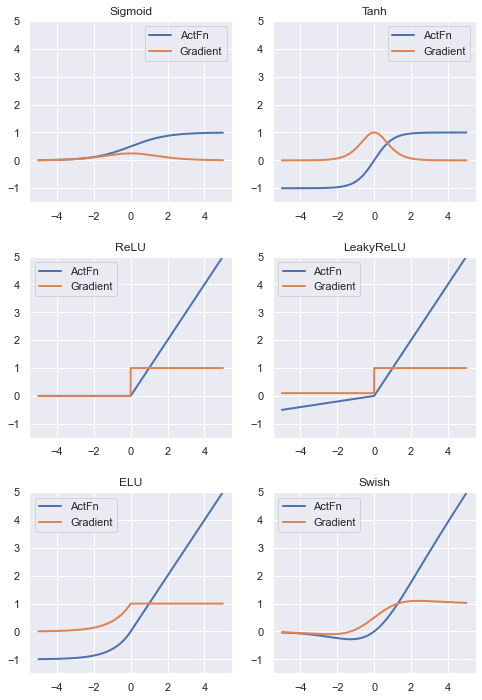

In [10]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    
    ax.plot(x, y, linewidth=2, label='ActFn')
    ax.plot(x, y_grads, linewidth=2, label='Gradient')
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())
    

act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)

cols = 2
rows = math.ceil(len(act_fns) / float(cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)

fig.subplots_adjust(hspace=0.3)
plt.show()

# BaseNetwork

In [11]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        layer_size_last = layer_sizes[0]
        
        for layer_size in layer_sizes[1:]:
            layers += [nn.Linear(layer_size_last, layer_size), act_fn]
            layer_size_last = layer_size
        
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        
        self.layers = nn.Sequential(*layers)
        
        self.config = {
            'act_fn' : act_fn.config,
            'input_size' : input_size,
            'num_classes' : num_classes,
            'hidden_sizes' : hidden_sizes,
        }
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out

In [207]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + '.config')

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + '.tar')

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    
    assert os.path.isfile(config_file), f'Could not find the config file "{config_file}"'
    assert os.path.isfile(model_file), f'Could not find the model file "{model_file}"'
    
    with open(config_file) as f:
        config_dict = json.load(f)
    
    if net is None:
        act_fn_name = config_dict['act_fn'].pop('name').lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop('act_fn'))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, 'w') as f:
        json.dump(config_dict, f)
        
        torch.save(model.state_dict(), model_file)

In [66]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...


C:\Users\spruce\anaconda3\envs\light\lib\site-packages\torchvision\datasets\mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [82]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

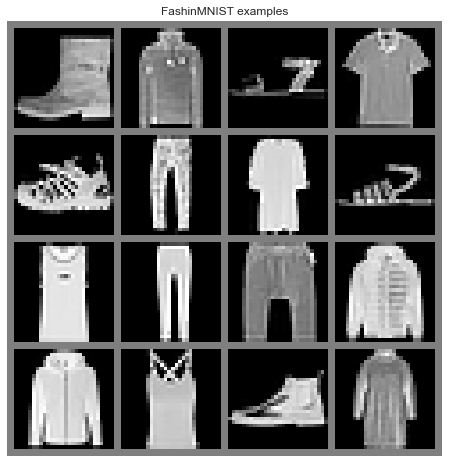

In [106]:
exmp_imgs = [train_set[i][0] for i in range(16)]

img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title('FashinMNIST examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
net = BaseNetwork(Sigmoid())

In [ ]:
net.zero_grad()
p

In [ ]:
net.eval()
small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
imgs, labels = next(iter(small_loader))
imgs, labels = imgs.to(device), labels.to(device)

net.to(device)
net.zero_grad()
preds = net(imgs)
loss = F.cross_entropy(preds, labels)
loss.backward()

In [134]:
def visualize_gradients(net, color='C0'):
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    
    grads = {
        name : params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if 'weight' in name}
    
    net.zero_grad()
    
    # plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel('Grad magnitude')
        fig_index += 1
    fig.suptitle(f'Gradient magnitude distribution for activation function {net.config["act_fn"]["name"]}', fontsize=14, y=1.05)
    
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

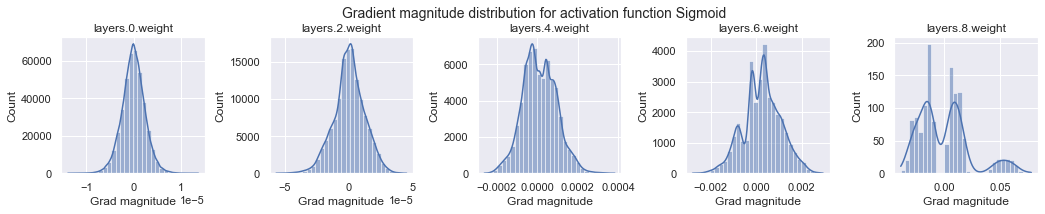

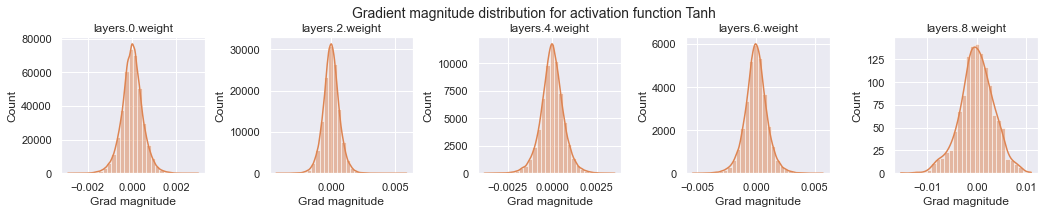

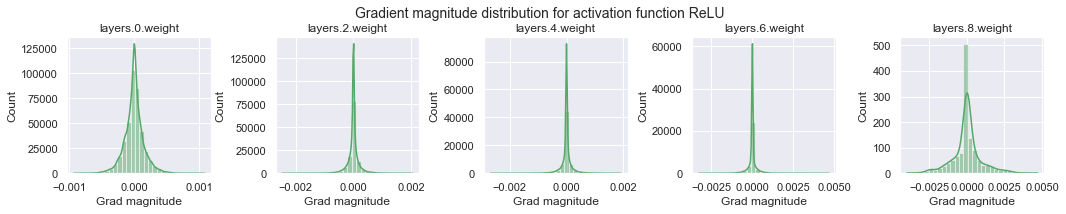

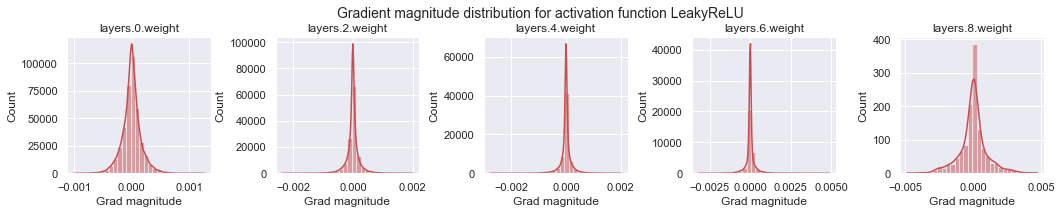

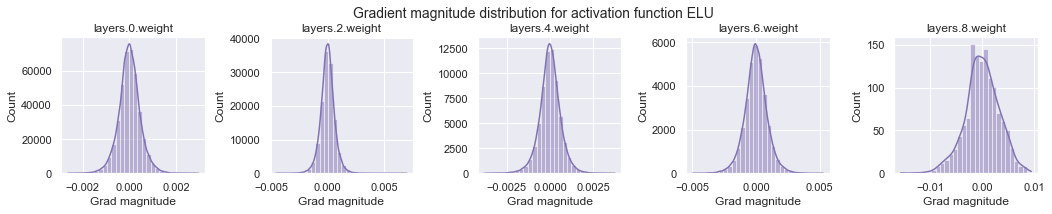

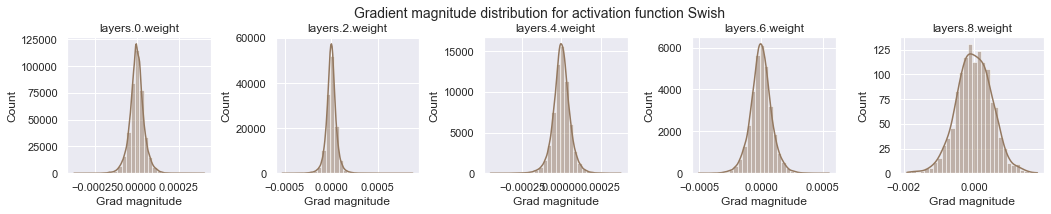

In [139]:
warnings.filterwarnings('ignore')

for i, act_fn_name in enumerate(tqdm(act_fn_by_name)):
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f'C{i}')

In [190]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    
    if file_exists and not overwrite: # file 존재하거나 overwrite를 하지 않을 경우
        print('Model file already exists. Skipping training..')
    else: # file이 없거나 overwrite를 할 경우
        if file_exists:
            print('Model file exists, but will be overwritten..')
            
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1

        for epoch in range(max_epochs):
            net.train()
            true_preds, count = 0.0, 0

            for imgs, labels in tqdm(train_loader_local, desc=f'Epoch {epoch+1}', leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()

                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()

                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)

            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print('\t (New best performance, saving model...)')
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f'Early stopping due to no improvement over the laset {patience} epochs')
                break

        plt.plot([i for i in range(1, len(val_scores) +1)], val_scores)
        plt.xlabel('Epochs')
        plt.ylabel('Validation accuracy')
        plt.title(f'Validation performance of {model_name}')
        plt.show()
        plt.close()
        
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print(f'Test accuracy : {test_acc*100.0:4.2f}% '.center(50, '=') + '\n')
    return test_acc

def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0.0, 0
    
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    
    test_acc = true_preds / count
    return test_acc

In [ ]:
for act_fn_name in act_fn_by_name:
    print(f'Training BaseNetwork with {act_fn_name} activation...')
    set_seed(42)
    
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f'FashionMNIST_{act_fn_name}', overwrite=False)

In [211]:
def visualize_activations(net, color='C0'):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, lables = next(iter(small_loader))
    
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    columns = 4
    rows = math.ceil(len(activations) / columns)
    
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat='density')
        key_ax.set_title(f'Layer {key} - {net.layers[key].__class__.__name__}')
        fig_index += 1
    
    fig.suptitle(f'Activation distribution for activation function {net.config["act_fn"]["name"]}', fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

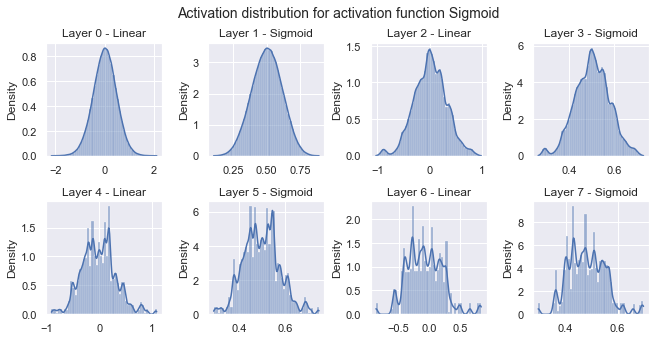

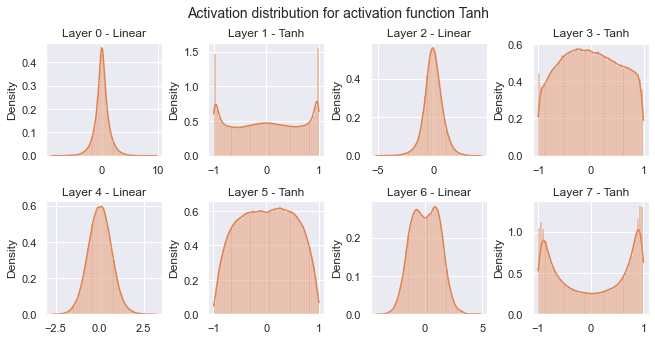

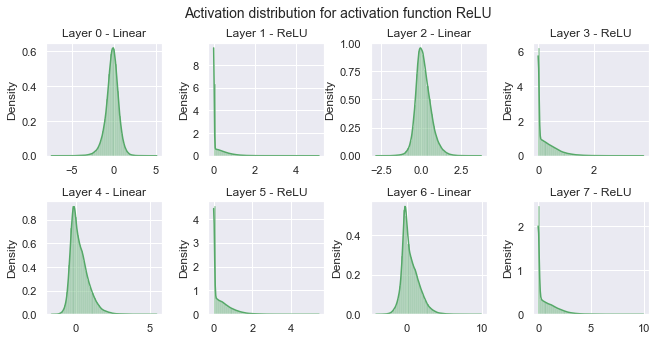

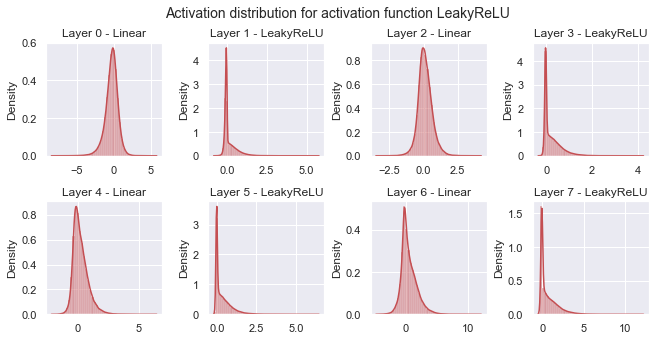

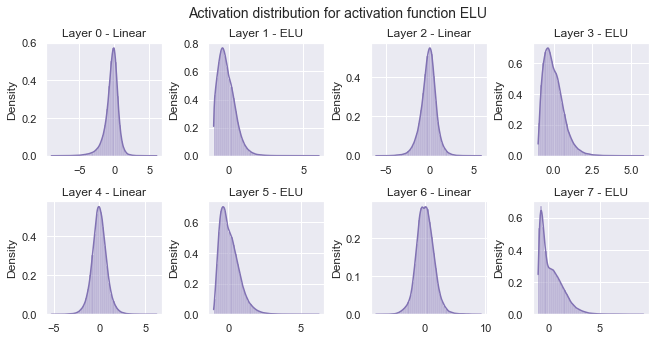

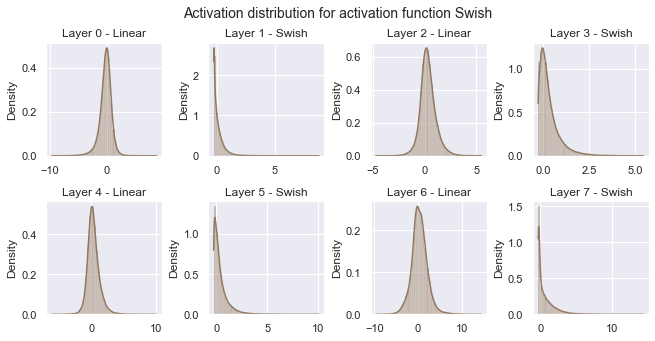

In [212]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f'FashionMNIST_{act_fn_name}').to(device)
    visualize_activations(net_actfn, color=f'C{i}')

In [223]:
for name, pa in net.named_parameters():
    print(name, pa.shape)

layers.0.weight torch.Size([512, 784])
layers.0.bias torch.Size([512])
layers.2.weight torch.Size([256, 512])
layers.2.bias torch.Size([256])
layers.4.weight torch.Size([256, 256])
layers.4.bias torch.Size([256])
layers.6.weight torch.Size([128, 256])
layers.6.bias torch.Size([128])
layers.8.weight torch.Size([10, 128])
layers.8.bias torch.Size([10])


In [224]:
net.layers[0]

Linear(in_features=784, out_features=512, bias=True)

In [220]:
net.layers[2]

Linear(in_features=512, out_features=256, bias=True)

In [216]:
for layer in net.layers[:-1]:
    print(layer.weight.shape)

torch.Size([512, 784])


AttributeError: 'Sigmoid' object has no attribute 'weight'

In [251]:
for i, label in train_loader:
    print(i.view(i.size(0), -1).shape)
    break

torch.Size([1024, 784])


In [239]:
isinstance(net.layers[1], ActivationFunction)

True

In [237]:
ActivationFunction

__main__.ActivationFunction

In [252]:
torch.ones(net.layers[0].weight.shape[0]).shape

torch.Size([512])

In [259]:
dead = torch.ones(net.layers[0].weight.shape[0])

In [260]:
dead.shape

torch.Size([512])

In [254]:
imgs = i.view(i.size(0), -1)

In [258]:
imgs.shape

torch.Size([1024, 784])

In [256]:
imim = net.layers[0](imgs.to(device))

In [265]:
imim.shape

torch.Size([1024, 512])

In [268]:
(imim==0).all(dim=0).shape

torch.Size([512])

In [278]:
(imim==0).all(dim=1)

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [270]:
(imim==0).all().shape

torch.Size([])

In [264]:
torch.logical_and(dead.to(device), (imim==0).all(dim=0)).shape

torch.Size([512])

In [ ]:
iiimmm = imim.view(

In [282]:
@torch.no_grad()
def measure_number_dead_neurons(net):
    
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)]
    
    net.eval()
    
    for imgs, labels in tqdm(train_loader, leave=False):
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs==0).all(dim=0))
                layer_index += 1
    
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print('Number of dead neurons :', number_neurons_dead)
    print('In percentage :', ', '.join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]),)

In [283]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 3, 10]
In percentage : 0.00%, 0.00%, 1.17%, 7.81%


In [288]:
set_seed(42)
net_leaky = BaseNetwork(act_fn=LeakyReLU()).to(device)
measure_number_dead_neurons(net_leaky)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 0, 0]
In percentage : 0.00%, 0.00%, 0.00%, 0.00%


In [287]:
set_seed(42)
net_elu = BaseNetwork(act_fn=ELU()).to(device)
measure_number_dead_neurons(net_elu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 0, 0]
In percentage : 0.00%, 0.00%, 0.00%, 0.00%


In [286]:
set_seed(42)
net_swish = BaseNetwork(act_fn=Swish()).to(device)
measure_number_dead_neurons(net_swish)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 0, 0]
In percentage : 0.00%, 0.00%, 0.00%, 0.00%


In [285]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name='FashionMNIST_relu').to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 2, 5]
In percentage : 0.00%, 0.00%, 0.78%, 3.91%


In [289]:
set_seed(42)
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage : 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


In [290]:
set_seed(42)
net_swish = BaseNetwork(
    act_fn=Swish(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],).to(device)
measure_number_dead_neurons(net_swish)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In percentage : 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%
